In [337]:
import pandas as pd


In [338]:
file_path = '/content/drive/MyDrive/MCD/Ingeniería de caracteristicas/proyecto grupo whatsapp/Chat de WhatsApp con Petit comité Deluxe - Cineclub LCC.txt'

Abriendo el archivo del grupo de wha

In [339]:
with open(file_path, 'r', encoding='utf-8') as f:
    data = f.readlines()

df = pd.DataFrame(data)

Creando columnas a partir de separadores en los mensajes

In [340]:
df[['fecha', 'resto']] = df[0].str.split(', ', n=1, expand=True) #sacando solo la fecha del resto del mensaje

In [341]:
df.drop(columns=[0], inplace=True) #Esto quita la columna original que es en la que venia el texto raw

In [342]:
df[['hora', 'resto']] = df['resto'].str.split(' - ', n=1, expand=True) #Sacando solo la hora del resto del mensaje

In [343]:
df[['nombre', 'mensaje']] = df['resto'].str.split(': ', n=1, expand=True)
df.drop(columns=['resto'], inplace=True) # ya que tenemos todas las partes del mensaje no necesitamos la columna llamada "resto"

Hay algunas filas en las que se registraron "logs" de whatsapp (mensajes sin autor) por lo que algunos registros de "autor" tienen un mensaje y su registro de mensaje es "None" para esto vamos a hacer un intercambio en estos datos entre los valores de "mensaje" y "autor" para que quede con autor = None y con el contenido del mensaje en la columna correspondeinte.

In [344]:
# Identificar las filas donde mensaje es None
sin_autor = df['mensaje'].isna()

# INTERCAMBIAR LOS VALORES: nombre -> resto, y nombre -> None
df.loc[sin_autor, 'mensaje'] = df.loc[sin_autor, 'nombre']
df.loc[sin_autor, 'nombre'] = None


In [345]:
#Cambiando el tipo de dato de fecha y eliminando los datos que no tienen una fecha en "fecha"
#(Son datos vacíos o mensajes muy mal exportados que no nos sirven)

import re

# Patrón para fecha en formato dd/mm/yyyy o dd/mm/yy
patron_fecha = r'^\d{1,2}/\d{1,2}/\d{2,4}$'

# Identificar filas válidas (que SÍ coinciden con el patrón)
fechas_validas = df['fecha'].str.match(patron_fecha, na=False)

# CREAR NUEVO DF solo con filas válidas
df_limpio = df[fechas_validas].copy()

#pasando las fechas a formato date
df_limpio['fecha'] = pd.to_datetime(df_limpio['fecha'], format='%d/%m/%Y')

In [346]:
#Creando una columna de hora más manejable para estadísticas (formato datetime)
df_limpio['hora'] = df_limpio['hora'].str.replace(' ', '').str.replace('.', '')

In [347]:
def convertir_hora_con_minutos(hora_str):
    if pd.isna(hora_str):
        return pd.NaT

    try:
        hora_str = str(hora_str).lower().replace(' ', '')

        # Patrón para "12:44pm", "7:21am", etc.
        import re
        match = re.match(r'(\d{1,2}):(\d{2})(am|pm)', hora_str)

        if match:
            hora = int(match.group(1))
            minutos = int(match.group(2))
            periodo = match.group(3)

            # Conversión de 12h a 24h
            if periodo == 'am':
                if hora == 12:
                    hora_24h = 0  # 12:00 am = 00:00
                else:
                    hora_24h = hora  # 1-11 am se mantienen
            else:  # pm
                if hora == 12:
                    hora_24h = 12  # 12:00 pm = 12:00
                else:
                    hora_24h = hora + 12  # 1-11 pm + 12

            from datetime import time
            return time(hora_24h, minutos)

        return pd.NaT
    except:
        return pd.NaT

df_limpio['hora_time'] = df_limpio['hora'].apply(convertir_hora_con_minutos)

In [348]:
#mezclando fecha y hora_time para obtener columna fecha y hora en formato datetime
df_limpio['fecha_hora'] = pd.to_datetime(df_limpio['fecha'].astype(str) + ' ' + df_limpio['hora_time'].astype(str))

In [349]:
#Podemos quitar las columnas anteriores de fecha y hora
df_limpio.drop(columns=['fecha', 'hora', 'hora_time'], inplace=True)
#reorganizando el orden de las columnas
df_limpio = df_limpio[['fecha_hora'] + [col for col in df_limpio.columns if col != 'fecha_hora']]

In [350]:
#lista de valores unicos de "nombre"
nombres = df_limpio['nombre'].unique()
df_limpio['nombre'].unique().shape

(12,)

In [351]:
#lista de nombres de ficcion (con 12 nombres segun la cantidad de valores unicos de "nombres")
new_names = ['None', 'Joker', 'Clay Face', 'Moonknight', 'Bane', 'Lex Luthor', 'Harley Quinn', 'Batman', 'Alfred', 'Cyborg', 'Wonder Woman', 'Green Lantern']

In [352]:
#reemplazando los nombres en el df por los nuevos nombres
df_limpio['nombre'] = df_limpio['nombre'].replace(nombres, new_names)

In [353]:
#quitando las ocurrencias de "\n" de todos los mensjaes
df_limpio['mensaje'] = df_limpio['mensaje'].str.replace('\n', ' ')

Agregando las columnas de la tarea:

In [354]:
#Nueva columna: tipo, si el mensaje es diferente de "<Multimedia omitido>" tipo = 'texto', en caso contrario tipo = 'multimedia'
df_limpio['tipo'] = df_limpio['mensaje'].apply(lambda x: 'texto' if x.strip() != '<Multimedia omitido>' else 'multimedia')

In [355]:
#Agregando columna de numero de palabras por mensaje
df_limpio['num_palabras'] = df_limpio['mensaje'].apply(lambda x: len(x.split()))
#si es de tipo multimedia -2
df_limpio.loc[df_limpio['tipo'] == 'multimedia', 'num_palabras'] -=2

In [356]:
df_limpio

,fecha_hora,nombre,mensaje,tipo,num_palabras
0,2024-08-29 12:44:00,None,‎~ Pikls cambió el ícono de este grupo,texto,8
1,2024-08-29 12:44:00,None,"‎~ Pikls creó el grupo ""Petit comité - Cineclu...",texto,10
2,2024-08-29 12:44:00,None,‎~ Pikls te añadió,texto,4
3,2024-08-29 12:44:00,Joker,<Multimedia omitido>,multimedia,0
4,2024-08-29 12:44:00,Clay Face,<Multimedia omitido>,multimedia,0
...,...,...,...,...,...
5721,2025-10-02 07:22:00,Green Lantern,<Multimedia omitido>,multimedia,0
5722,2025-10-02 07:36:00,Joker,JODER SI,texto,2
5723,2025-10-02 07:37:00,Joker,Q basado amaneciste xema,texto,4
5724,2025-10-02 07:59:00,Joker,Yo,texto,1


Estadísticas Descriptivas:

In [357]:
#Numero de usuarios
num_usuarios = df_limpio['nombre'].nunique()

#Promedio de mensajes por usuario
promedio_mensajes = df_limpio.groupby('nombre')['mensaje'].count().mean()

#Numero de mensajes
num_mensajes = df_limpio['mensaje'].count()

#Usuario con menos mensajes
usuario_menos_mensajes = df_limpio.groupby('nombre')['mensaje'].count().idxmin()
#cantidad de mensajes de usuario con menos mensajes
num_mensajes_usuario_menos_mensajes = df_limpio[df_limpio['nombre'] == usuario_menos_mensajes].shape[0]

#Usuario con mas mensajes
usuario_mas_mensajes = df_limpio.groupby('nombre')['mensaje'].count().idxmax()
#cantidad de mensajes de usuario con mas mensajes
num_mensajes_usuario_mas_mensajes = df_limpio[df_limpio['nombre'] == usuario_mas_mensajes].shape[0]


#promedio de palabras por mensaje
promedio_palabras = df_limpio.groupby('nombre')['num_palabras'].mean()

#Numero de palabras de mensaje con mas palabras
palabras_msg_mas_palabras = df_limpio['num_palabras'].max()

print(f'Numero de usuarios: {num_usuarios}')
print(f'Promedio de mensajes por usuario: {promedio_mensajes}')
print(f'Numero de mensajes: {num_mensajes}')
print(f'Usuario con menos mensajes: {usuario_menos_mensajes} ({num_mensajes_usuario_menos_mensajes} mensajes)')
print(f'Usuario con mas mensajes: {usuario_mas_mensajes} ({num_mensajes_usuario_mas_mensajes} mensajes)')
print(f'Promedio de palabras por mensaje:\n {promedio_palabras}')
print(f'Numero de palabras de mensaje con mas palabras: {palabras_msg_mas_palabras}')

Numero de usuarios: 12
Promedio de mensajes por usuario: 454.8333333333333
Numero de mensajes: 5458
Usuario con menos mensajes: Green Lantern (12 mensajes)
Usuario con mas mensajes: Joker (2635 mensajes)
Promedio de palabras por mensaje:
 nombre
Alfred            3.792683
Bane              5.692661
Batman            4.976190
Clay Face         5.072052
Cyborg            5.595745
Green Lantern     5.583333
Harley Quinn      3.200000
Joker             3.492600
Lex Luthor        2.919942
Moonknight        5.703583
None             10.050000
Wonder Woman      3.478261
Name: num_palabras, dtype: float64
Numero de palabras de mensaje con mas palabras: 74


In [358]:
#Lista: Numero de mensajes por usuario
num_mensajes_por_usuario = df_limpio.groupby('nombre')['mensaje'].count()
num_mensajes_por_usuario

,mensaje
nombre,
Alfred,82
Bane,1090
Batman,42
Clay Face,458
Cyborg,47
Green Lantern,12
Harley Quinn,55
Joker,2635
Lex Luthor,687


<Axes: xlabel='nombre'>

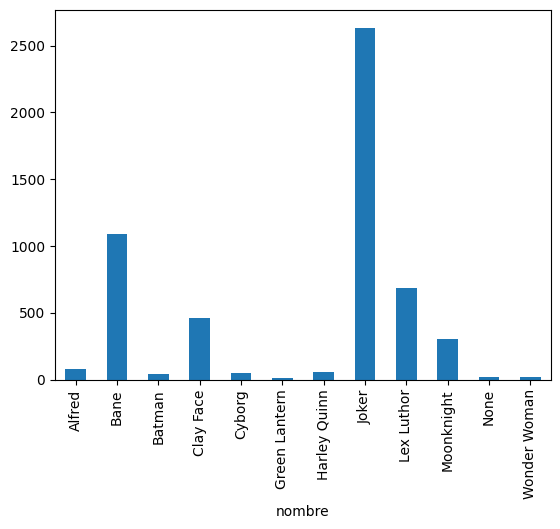

In [359]:
#Gráfica de usuarios mas activos
num_mensajes_por_usuario.plot(kind='bar')

In [360]:
#pasando todo el texto a minusculas
df_limpio['mensaje'] = df_limpio['mensaje'].str.lower()

In [361]:
#quitando catacteres especiales o invisibles
df_limpio['mensaje'] = df_limpio['mensaje'].str.replace('[^\w\s]', '')

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3929570635.py:2: SyntaxWarning: invalid escape sequence '\w'
  df_limpio['mensaje'] = df_limpio['mensaje'].str.replace('[^\w\s]', '')


In [362]:
#Quitando nombres de personas
df_limpio['mensaje'] = df_limpio['mensaje'].apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))
#quitando nombres que aparezcan en nombres.txt
nombres = pd.read_csv('/content/drive/MyDrive/MCD/Ingeniería de caracteristicas/proyecto grupo whatsapp/nombres.txt', header=None)
nombres = nombres[0].tolist()
df_limpio['mensaje'] = df_limpio['mensaje'].apply(lambda x: ' '.join([word for word in x.split() if word not in nombres]))
df_limpio = df_limpio[~df_limpio['mensaje'].str.contains('|'.join(nombres))]

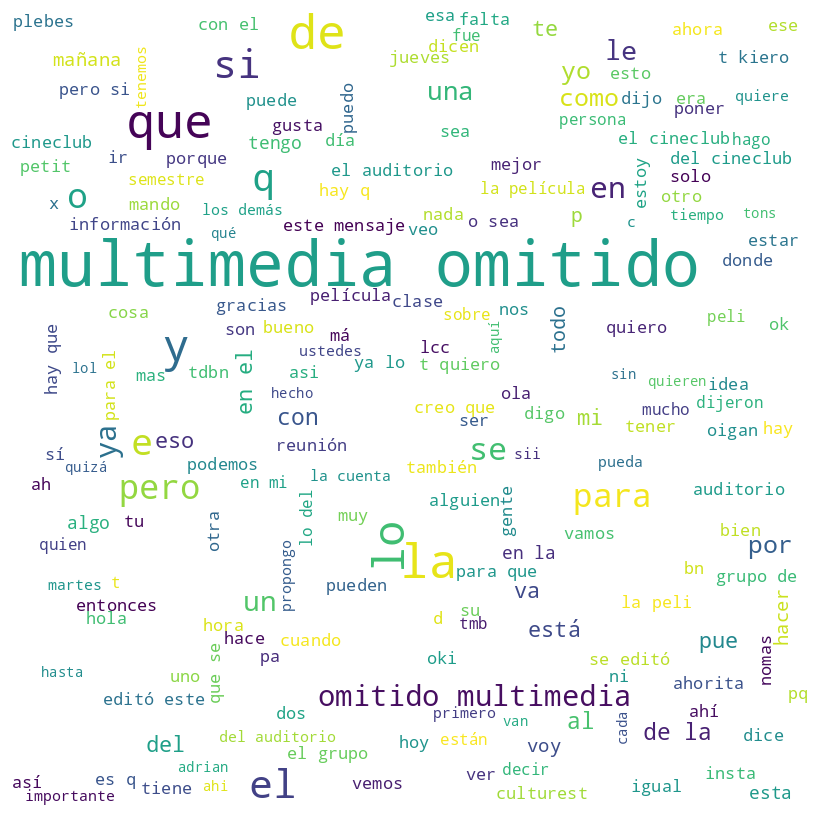

In [363]:
#WordCloud de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(df_limpio['mensaje']))

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.close()

In [364]:
#Quitando stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))

df_msg_texto = df_limpio[df_limpio['tipo'] == 'texto']

#agregando si, q, pue, a stopwords
stop_words.update(['si', 'q', 'pue', 'a'])

df_msg_texto['mensaje'] = df_msg_texto['mensaje'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-111449290.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msg_texto['mensaje'] = df_msg_texto['mensaje'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))


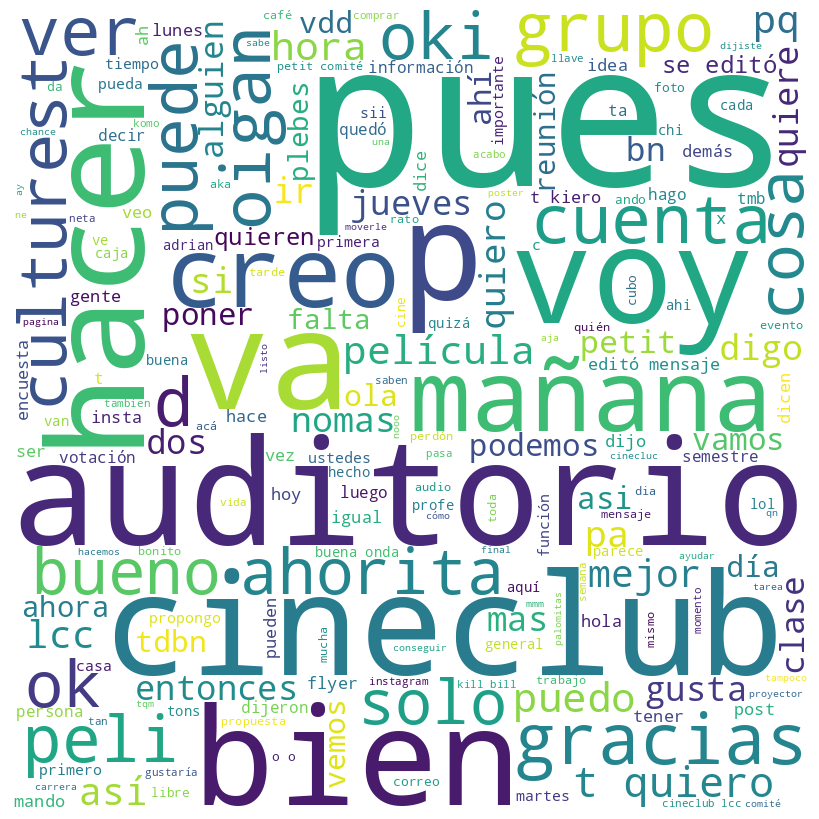

In [365]:
#rehaciendo wordcloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(df_msg_texto['mensaje']))

#mostrando wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.close()

In [366]:
df_msg_texto

,fecha_hora,nombre,mensaje,tipo,num_palabras
0,2024-08-29 12:44:00,None,‎~ pikls cambió ícono grupo,texto,8
1,2024-08-29 12:44:00,None,"‎~ pikls creó grupo ""petit comité - cineclub l...",texto,10
2,2024-08-29 12:44:00,None,‎~ pikls añadió,texto,4
5,2024-08-29 12:47:00,Joker,hoy voy dedicarme rato escribir vimos hoy,texto,14
6,2024-08-29 12:47:00,Joker,pues ver puedo ir organizando mandarselos aca,texto,11
...,...,...,...,...,...
5720,2025-10-02 07:21:00,Green Lantern,"macario, habla muerte",texto,9
5722,2025-10-02 07:36:00,Joker,joder,texto,2
5723,2025-10-02 07:37:00,Joker,basado amaneciste xema,texto,4
5724,2025-10-02 07:59:00,Joker,,texto,1


<Axes: >

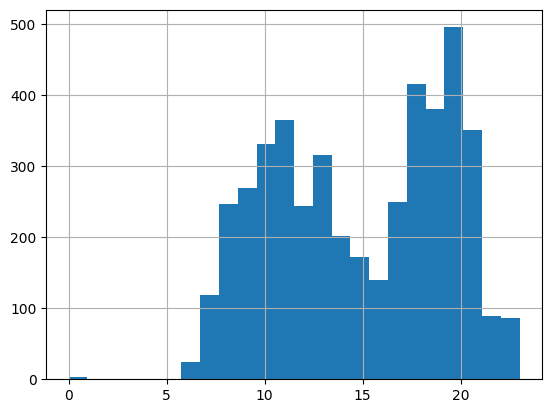

In [367]:
#Distribución de los mensajes a lo largo del día
df_msg_texto['fecha_hora'].dt.hour.hist(bins=24)

<Axes: xlabel='fecha_hora'>

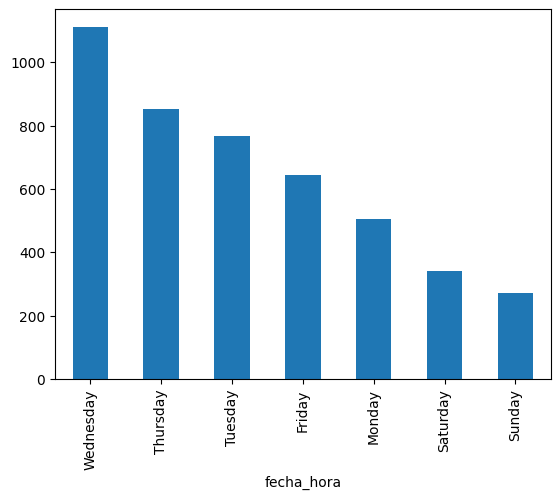

In [368]:
#Cantidad de mensajes por día de la semana
df_msg_texto['fecha_hora'].dt.day_name().value_counts().plot(kind='bar')

<Figure size 1200x800 with 0 Axes>

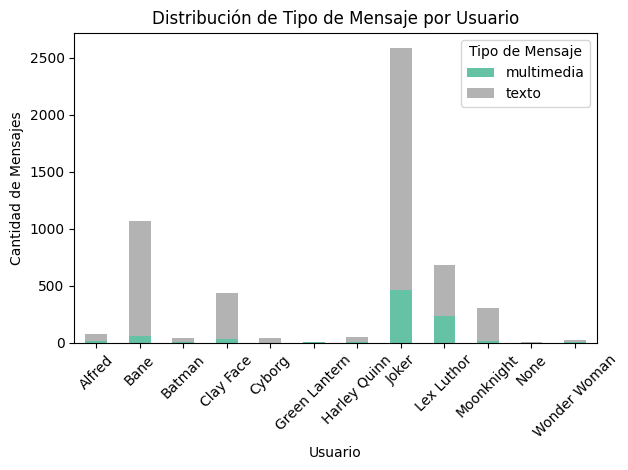

In [369]:
#Texto vs Multimedia por usuario gráfica comparativa por usuario

pivot_tipo = df_limpio.pivot_table(
    index='nombre',
    columns='tipo',
    values='fecha_hora',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12, 8))
pivot_tipo.plot(kind='bar', stacked=True, colormap='Set2')
plt.title('Distribución de Tipo de Mensaje por Usuario')
plt.xlabel('Usuario')
plt.ylabel('Cantidad de Mensajes')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Mensaje')
plt.tight_layout()
plt.show()

In [373]:
#Viendo las palabras menos comunes
from collections import Counter

least_common = Counter(' '.join(df_msg_texto['mensaje']).split()).most_common()[-20:]
least_common

[('busco', 1),
 ('besame', 1),
 ('rec', 1),
 ('rico', 1),
 ('recomendada', 1),
 ('oookay', 1),
 ('tecnología', 1),
 ('inscriben', 1),
 ('convocatorias', 1),
 ('hackaton', 1),
 ('noviembre', 1),
 ('muridos', 1),
 ('>>>>>>>>>', 1),
 ('coco', 1),
 ('macario,', 1),
 ('muerte', 1),
 ('amaneciste', 1),
 ('xema', 1),
 ('marta', 1),
 ('higareda', 1)]